<a href="https://colab.research.google.com/github/gsfreitas/engenharia-medica/blob/main/atividade_pratica_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A start-up de Engenharia Biomédica na qual você trabalha é apoiada por uma grande indústria farmacêutica que pretende desenvolver novos produtos para o tratamento do Diabetes. Como fruto desta parceria, você recebeu registros de
variabilidade glicêmica de mais de 350 pacientes divididos em duas classes: pacientes com diabetes tipo 2 e indivíduos saudáveis do grupo controle. Os registros eram coletados pelos próprios pacientes em um protótipo de glicosímetro portátil automatizado e 9 biomarcadores foram extraídos a partir de tais registros. Tais biomarcadores estão disponíveis no arquivo .mat contido no material da aula 12 no Classroom *(o arquivo contém dois arrays: “Dados” = matriz com características por padrões; “Classes” = vetor com as classes de cada padrão, sendo 0 = indivíduos hígidos e 1 = pacientes com diabetes)*.

In [ ]:
# importando as bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import itertools
import scipy.io
import scipy.fft as fft
from scipy.signal import welch
from sklearn import svm
from scipy.stats import shapiro
import seaborn as sns
import operator
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# leitura e tratamento dos dados
data = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-5/Dados.mat")['Dados']
classes = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-5/Dados.mat")['Classes']

In [ ]:
# criando um vetor referência unidimensional
mask = classes.ravel()

# separando as classes
higidos = data[:, mask==0]
saudaveis = data[:, mask==1]

Prepare um espaço com três características escolhidas por você visando melhor separar as classes. O código deve plotar as duas classes no espaço tridimensional escolhido. Além disso, você deverá embasar, da maneira mais completa e apropriada que puder, a escolha realizada.

Vamos realizar essa escolha baseando-se na seleção vetorial. Já que queremos obter as melhores características no espaço, então esse método é ideal, pois ele calcula a distância entre as classes para ficar mais nítida a distinção entre elas.

In [ ]:
def t3_remoutliers(padroes,p,method='desvio'):
   #Encontra outlires baseando-se em dois métodos possiveis:
    #  method = 'desvio': mediana +-p x desvio
    #  method = 'quartis': quartis  +-p x intervalo entre quartis
    # padroes = numpy array de uma característica (N x 1)
    # p = numero de desvios ou de intervalos entre quartis a ser empregado
    # retorna lista com as posicoes dos outliers no array
    if method =='desvio':
        md=np.median(padroes)
        std=np.std(padroes,ddof=1)
        th1=md+p*std
        th2=md-p*std
    elif method=='quartis':
        q3, q1 = np.percentile(padroes, [75 ,25])
        iqr=q3-q1
        th1=q3+p*iqr
        th2=q1-p*iqr
    outliers=(padroes>th1) | (padroes<th2)
    outs=[i for i, val in enumerate(outliers) if val]
    return outs

In [ ]:
higidos.shape

(9, 179)

In [ ]:
higidos.T.shape

(179, 9)

In [ ]:
# criando array com o nome dos trechos
trechos = ['higidos', 'saudaveis']

# criando listas para armazenar os outliers de cada trecho
out_higidos = []
out_saudaveis = []

# iterando sobre cada lista para receber os outliers
for index in range(0,9):
  out_higidos.append(t3_remoutliers(higidos.T[:,index], 3, 'desvio'))
  out_saudaveis.append(t3_remoutliers(saudaveis.T[:,index], 3, 'desvio'))

# contando os valores únicos de outliers de cada trecho
outliers = [list(set(valor for sublista in out_higidos for valor in sublista)),
            list(set(valor for sublista in out_saudaveis for valor in sublista))]

# print com a quantidade de outliers de cada trecho
for index in range(len(outliers)):
  print(f"Quantidade de outliers {trechos[index]}: {len(outliers[index])}")

Quantidade de outliers higidos: 19
Quantidade de outliers saudaveis: 21


In [ ]:
# removendo os outliers
for index in range(9):
    no_out_higidos = np.delete(higidos.T, out_higidos[index], axis=0)
    no_out_saudaveis = np.delete(saudaveis.T, out_saudaveis[index], axis=0)

In [ ]:
no_out_saudaveis[8].shape

(9,)

In [ ]:
def t3_normaliza(dados,metodo='linear',r=1):
    #Realiza a normalizacao de um conjunto de padroes
    # dados = numpy array com padroes de uma caracteristica N x 1
    # metodo ='linear' : normalizacao linear (padrao)
    #        = 'mmx': limitada entre -1 e 1
    #        = 'sfm': rescala nao linear no intervalo 0 a 1
    # r = parametro do metodo sfm (padrao =1)
    #A função retorna os dados normalizados
    if metodo=='linear':
        M=np.mean(dados)
        S=np.std(dados,ddof=1)
        dadosnorm=(dados-M)/S
    elif metodo=='mmx':
        dadosnorm=2*dados/(np.max(dados)-np.min(dados))
        dadosnorm=dadosnorm - (np.min(dadosnorm)+1)
    elif metodo=='sfm':
        x=dados-np.mean(dados)
        x=-x/(r*np.std(dados))
        dadosnorm=1/(1+np.exp(x))
    return dadosnorm

In [ ]:
# calculando as dimensoes das classes
(lh, ch) = np.shape(no_out_higidos)
(ls, cs) = np.shape(no_out_saudaveis)

# calculo de todas as dimensoes
all_dimensions = lh + ls
zeros = np.zeros(lh)
ones = np.ones(all_dimensions-len(zeros))
all_classes = np.concatenate((zeros, ones))

# junta as duas classes
all_data = np.concatenate((no_out_higidos, no_out_saudaveis))

# define o metodo
method = ['linear']

norm = np.zeros_like(all_data)
# Laco for para normalizacao
for metodo in method:
    for i in range(np.size(all_data, axis=1)):
        # Normalizando cada variavel
        norm[:,i] = t3_normaliza(all_data[:,i], metodo)

# Separando os dados normalizados para cada variavel
norm_higidos = norm[all_classes == 0].T
norm_saudaveis = norm[all_classes == 1].T

In [ ]:
def t3_matrizesdeespalhamento(classes,selcars):
    #Calcula as matrizes de espalhamento a partir de uma lista de classes
    #Inputs:
    # - classes = lista em que cada elemento corresponde a um array características x padrões de cada classe
    # - selcars = índice de quais características usar no cálculo das matrizes
    #Outputs:
    # - matrizes de espalhamento: SW, SM e SB
    Ncl=len(classes)
    mean_vectors=[]
    for cl in range(Ncl):
        mean_vectors.append(np.mean(classes[cl][selcars,:],axis=1))
    prob=np.zeros(Ncl)
    N=0
    for i in range(Ncl):
        prob[i]=np.size(classes[i][selcars,:],axis=1)
        N=N+prob[i]
    prob=prob/N
    Ncar=len(selcars)
    SW=np.zeros((Ncar,Ncar))#within classes
    for cl in range(Ncl):
        varwithin=np.cov(classes[cl][selcars,:],ddof=0)
        SW=SW+prob[cl]*varwithin
    allclasses=classes[0][selcars,:]
    for cl in range(Ncl-1):
        allclasses=np.concatenate((allclasses,classes[cl+1][selcars,:]),axis=1)
    SM=np.cov(allclasses,ddof=0)
    SB = SM - SW
    return SW,SM,SB

In [ ]:
def t3_selvetorial(classes,n):
    #Calcula os critérios para seleção vetorial exaustiva de n características
    #Inputs:
    # - classes = lista em que cada elemento corresponde a um array características x padrões de cada classe
    # - n = número de características para selecionar
    #Outputs:
    # - J1, J2 e J3: critérios da seleção vetorial
    # - combs: lista com as características empregadas para cada valor de critério
    Ncar=np.size(classes[0],axis=0)
    combs=list(itertools.combinations(range(Ncar),n))
    J1=np.zeros(len(combs))
    J2=np.zeros(len(combs))
    J3=np.zeros(len(combs))
    for i in range(len(combs)): #todas combinacoes
        SW,SM,SB=t3_matrizesdeespalhamento(classes,combs[i])
        J1[i]=np.trace(SM)/np.trace(SW)
        J2[i]=np.linalg.det(SM)/np.linalg.det(SW)
        J3[i]=np.trace(np.dot(np.linalg.inv(SW),SM))/np.size(SW,axis=0)
    return J1, J2, J3, combs

In [ ]:
# juntando as classes
classes = [norm_higidos, norm_saudaveis]

# aplicando a função de seleção vetorial
J1, J2, J3, combs = t3_selvetorial(classes, 3)

print(f"Combinações de características: {combs}")

Combinações de características: [(0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (0, 1, 8), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 2, 6), (0, 2, 7), (0, 2, 8), (0, 3, 4), (0, 3, 5), (0, 3, 6), (0, 3, 7), (0, 3, 8), (0, 4, 5), (0, 4, 6), (0, 4, 7), (0, 4, 8), (0, 5, 6), (0, 5, 7), (0, 5, 8), (0, 6, 7), (0, 6, 8), (0, 7, 8), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 2, 6), (1, 2, 7), (1, 2, 8), (1, 3, 4), (1, 3, 5), (1, 3, 6), (1, 3, 7), (1, 3, 8), (1, 4, 5), (1, 4, 6), (1, 4, 7), (1, 4, 8), (1, 5, 6), (1, 5, 7), (1, 5, 8), (1, 6, 7), (1, 6, 8), (1, 7, 8), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 3, 7), (2, 3, 8), (2, 4, 5), (2, 4, 6), (2, 4, 7), (2, 4, 8), (2, 5, 6), (2, 5, 7), (2, 5, 8), (2, 6, 7), (2, 6, 8), (2, 7, 8), (3, 4, 5), (3, 4, 6), (3, 4, 7), (3, 4, 8), (3, 5, 6), (3, 5, 7), (3, 5, 8), (3, 6, 7), (3, 6, 8), (3, 7, 8), (4, 5, 6), (4, 5, 7), (4, 5, 8), (4, 6, 7), (4, 6, 8), (4, 7, 8), (5, 6, 7), (5, 6, 8), (5, 7, 8), (6, 7, 8)]


In [ ]:
# selecionando a melhor combinação com base no J3
best_position = np.argmax(J3)
best_comb = combs[best_position]
best_comb

(1, 7, 8)

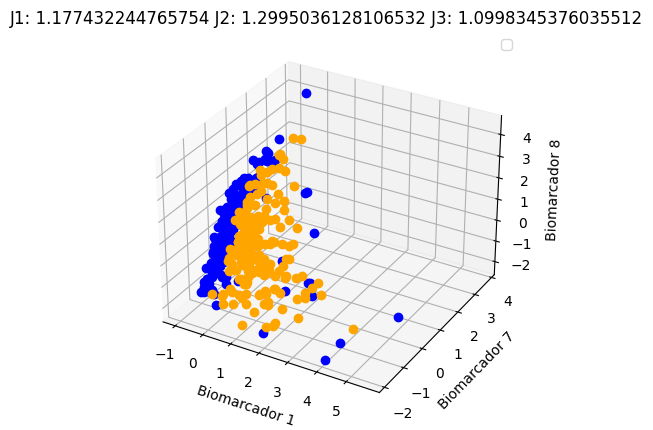

In [ ]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection='3d')
ax.plot(norm_higidos[1], norm_higidos[7], norm_higidos[8], 'o', fillstyle='full', color='blue')
ax.plot(norm_saudaveis[1], norm_saudaveis[7], norm_saudaveis[8], 'o', fillstyle='full', color='orange')


# Configurar rótulos dos eixos
ax.set_xlabel('Biomarcador 1')
ax.set_ylabel('Biomarcador 7')
ax.set_zlabel('Biomarcador 8')

# Exibir o gráfico
plt.legend()
plt.title(f"J1: {np.max(J1)} J2: {np.max(J2)} J3: {np.max(J3)}")
plt.show()

**b)** Se você fosse utilizar uma análise de componentes principais para transformar o espaço de características em um espaço tridimensional de componentes principais, quais componentes você selecionaria tentando otimizar a separação das classes? Prepare o código para plotar as classes no espaço tridimensional escolhido, embasando, novamente da maneira mais completa e apropriada que puder, a escolha realizada.

In [ ]:
def t4_svd(dados,m):
     #Realiza a transformação do espaço de características usando a PCA:
     #Inputs:
     # - dados= matriz L x N (caracteristicas x padroes)
     # - m = dimensão do espaço de componentes principais
     #Outputs:
     # - w = autovalores
     # - v = autovetores
     # - mse = erro quadrático médio da projeção
     # - dadosproj = matriz contendo os dados projetados
    for i in range(np.size(dados,axis=0)):
        dados[i,:]=dados[i,:]-np.mean(dados[i,:])
    U,D,VT=np.linalg.svd(dados)
    w=D**2/np.size(dados,axis=1)
    comps=w.argsort()[::-1] #ordem decrescente
    comps=list(comps[0:m])
    v=U[:,comps]
    dadosproj=np.dot(v.T,dados)
    if m==1:
         dadosproj=dadosproj[0]
    mse=100*(1-sum(w[comps])/sum(w))
    w=w[comps]
    return w,mse,dadosproj,v

In [ ]:
# a unindo as duas classes
# a função pede características x padrões
all_data = np.concatenate((higidos, saudaveis), axis=1)

# aplicando o svd
w, mse, dadosproj, v = t4_svd(all_data, 3)

In [ ]:
v.shape

(9, 3)